In [1]:
import warnings
from langchain_ollama import ChatOllama
from langgraph.graph import MessagesState
from langchain_core.prompts import ChatPromptTemplate

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
llm = ChatOllama(model='llama3.1:8b', temperature=0.25)

In [3]:
from IPython.display import Image, display
from typing import Literal, Optional
from langgraph.graph import StateGraph, START, END


class GraphSchema(MessagesState):
    user_query: str
    normalized_query: str
    # feedback_normalized_query: str
    web_search_results: str
    wikipedia_search_results: str
    combined_summary: str
    human_feedback: Optional[str] = None
    feedback_sentiment: Optional[Literal['positive', 'negative']] = None

In [ ]:
## defining node function for query normalization
normalization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         """You are a query-normalization assistant whose job is to convert a user's free-text request into domain specific,
         concise, robust and well-structured web search and Wikipedia queries ready for lookup APIs.
         Output nothing except the rewritten query. remove conversational fluff words. Convert the user query to nouns,
         entities, industry/domain specific key technical terms. Avoid stopwords and conversational words; keep it compact and search-friendly.
         Example input → output mapping:
         “explain side effects of paracetamol overdose in kids” → “Acetaminophen overdose pediatric side effects”
         “updates on llm model quantization techniques” → “LLM quantization latest techniques”"""),

        ("human", 'user_query:"{query}"')
    ]
)

feedback_query_normalization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         """You are a recise query-normalization assistant whose job is to rewrite the previously generated normalized query for web and wikipedia lookup APIs,
         which must be domain specific, concise, robust and well-structured.
         Given the previously generated normalized query and the user feedback that requests for addition or removal of certain information,
         generate a single line improved normalized query that incorporates the user feedback.
         Do NOT output any explanation, only the rewritten query.
         Preserve existing entities and technical terms from the previous query unless the feedback explicitly asks to remove them.
         If feedback asks to add, include those topics as concise tokens. If feedback asks to remove a topic, omit it.
         Avoid stopwords and conversational words; keep it compact and search-friendly.
         Examples (input → output):
         1) Previous normalized query: \"Acetaminophen overdose pediatric side effects\"
            User Feedback: \"also include dosing thresholds and toxic metabolites\"
            Output: \"Acetaminophen overdose pediatric side effects dosing thresholds toxic metabolites\"
         2) Previous normalized query: \"LLM quantization latest techniques\"
            User Feedback: \"remove quantization, focus on pruning methods only\"
            Output: \"LLM pruning methods latest techniques\"
         3) Previous normalized query: \"diabetes type 2 treatment metformin sulfonylurea guidelines\"
            User Feedback: \"keep same but exclude sulfonylurea\"
            Output: \"diabetes type 2 treatment metformin guidelines\" """),

        ('human',
         'Previous normalized query:"{previous_normalized_query}"'
         'User Feedback:"{user_feedback}"'
        )
    ]
)


def query_normalization(state:GraphSchema):
    if (state.get('feedback_sentiment', None) is None) and (state.get('human_feedback', None) is None):
        final_prompt = normalization_prompt.format(query=state['user_query'])
        query = llm.invoke(input=final_prompt).content
        return {'normalized_query': query.strip('"')}

    elif (state.get('feedback_sentiment', None) == 'negative') and (state.get('human_feedback', None) is not None):
        final_prompt = feedback_query_normalization_prompt.format(
            previous_normalized_query=state['normalized_query'],
            user_feedback=state['human_feedback']
        )
        query = llm.invoke(input=final_prompt).content
        return {'normalized_query': query.strip('"')}


from langchain_community.tools.tavily_search import TavilySearchResults
import os

os.environ['TAVILY_API_KEY'] = "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"
tavily_search = TavilySearchResults(max_results=3)

## defining node function for web search
def web_search(state:GraphSchema):
    web_search = tavily_search.invoke(input=state["normalized_query"])
    formatted_search_docs = "\n\n-------------------------------\n\n".join(
        [
            f'Document url - "{doc["url"]}"\nDocument title - {doc["title"]}\nDocument content - {doc["content"]}'
            for doc in web_search
        ]
    )
    
    return {'web_search_results':[formatted_search_docs]}

## defining node functionality for wikipedia search
from langchain_community.document_loaders import WikipediaLoader

def wikipedia_search(state:GraphSchema):
    wiki_loader = WikipediaLoader(query=state['normalized_query'], load_max_docs=2).load()
    
    formatted_wiki_docs = "\n\n-------------------------------\n\n".join(
        [
            f'Document url - "{doc.metadata["source"]}"\nDocument title - {doc.metadata["title"]}\nDocument Summary - {doc.metadata["summary"]}'
            for doc in wiki_loader
        ]
    )

    return {'wikipedia_search_results':[formatted_wiki_docs]}

## final result generation node function
summarization_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are a synthesis assistant. Use ONLY the evidence content provided below to generate final results.
            Based on the provided user query and content, generate the summary with three sections: Introduction, Findings, and Conclusion.
            Atlast, provide the list of references used in the provided content.
            If a fact is not contained in the evidence, say that evidence is insufficient.
            Do not add or invent any external facts."""
        ),

        ('system', '{contents}'),
        ('human', '{user_query}')

    ]
)

def content_synthesis(state:GraphSchema):
    combined_contents = "\n\n-------------------------------\n\n".join(
        state['web_search_results'] + state['wikipedia_search_results']
    )

    summarization_formatted_prompt = summarization_prompt.format(
        contents=combined_contents,
        user_query=state['user_query']
    )

    final_response = llm.invoke(input=summarization_formatted_prompt).content

    return {'combined_summary': final_response}

## feedback collection node function
# feedback_analysis_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             'system',
#             "You are an expert sentiment analysis model. Your sole task is to analyze the provided user feedback and classify its emotional tone as positive or negative."
#             "Use the provided summary to understand the context of the feedback. The provided feedback may contain suggestions, criticisms, or praises regarding the summary."
#             "The provided feedback is not meant to add those points the summary but to express the user's sentiment towards the summary."
#             "Classify sentiment of ONLY the user feedback text and ignore the sentiment inside the summary. The summary is ONLY context."
#             "If feedback contains both positive and negative, classify by the dominant tone of the FEEDBACK ONLY."
#             "You must output only one token: positive or negative."
#         ),

#         ('system', "Summary (context only, not to be classified): '{summary}'"),
#         ('human', "Feedback to classify: '{feedback}'")
#     ]
# )

def feedback_collection(state:GraphSchema):
    feedback_sentiment = input("Is the provided summary good enough? (yes/no): ")
    if feedback_sentiment.lower() in ['yes', 'y']:
        return {'human_feedback': 'The generated summary is good enough.', 'feedback_sentiment': 'positive'}
    else:
        user_feedback = input("Kindly provided the content or modification you want in the generated summary: ")
        return {'human_feedback': user_feedback, 'feedback_sentiment': 'negative'}
    
## defining conditional function for query normalization
def needs_query_normalization(state:GraphSchema):
    if (state.get('feedback_sentiment',None) == 'negative') and (state.get('human_feedback',None) is not None):
        return 'query_normalization'
    return END

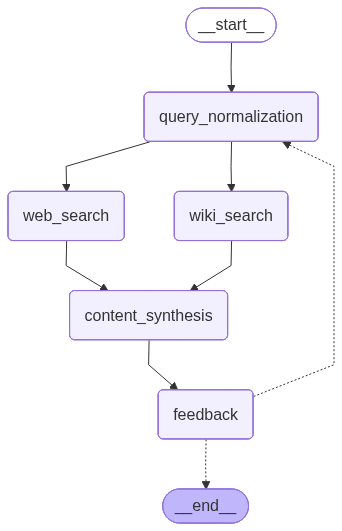

In [5]:
builder = StateGraph(state_schema=GraphSchema)
builder.add_node(node='query_normalization', action=query_normalization)
builder.add_node(node='web_search', action=web_search)
builder.add_node(node='wiki_search', action=wikipedia_search)
builder.add_node(node='content_synthesis', action=content_synthesis)
builder.add_node(node='feedback', action=feedback_collection)


builder.add_edge(start_key=START, end_key='query_normalization')
builder.add_edge(start_key='query_normalization', end_key='web_search')
builder.add_edge(start_key='query_normalization', end_key='wiki_search')
builder.add_edge(start_key='web_search', end_key='content_synthesis')
builder.add_edge(start_key='wiki_search', end_key='content_synthesis')
builder.add_edge(start_key='content_synthesis', end_key='feedback')
builder.add_conditional_edges(source='feedback', path=needs_query_normalization, path_map=['query_normalization', END])

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke(input={'user_query': "alcohol consumption effects on liver and latest treatment updates"})

Alcohol induced liver damage treatment options
no
add effect of alcohol on kideny too
Alcohol induced liver and kidney damage treatment options
yes


{'messages': [],
 'user_query': 'alcohol consumption effects on liver and latest treatment updates',
 'normalized_query': 'Alcohol induced liver and kidney damage treatment options',
 'web_search_results': ['Document url - "https://pmc.ncbi.nlm.nih.gov/articles/PMC9499849/"\nDocument title - Current Medical Treatment for Alcohol-Associated Liver Disease\nDocument content - ### Acute Kidney Injury-hepatorenal Syndrome Prevention and Treatment [...] from baseline.110 Up to 90% of patients with stage 1A AKI-HRS (serum creatinine <1.5 g/dL) may resolve with intravenous albumin at 1 g/kg/day for two days.109,111 It is also recommended that diuretics and beta-blockers (given their negative inotropic effect) should be withdrawn.109,111 In patients with AKI-HRS stage 1B (serum creatinine ≥1.5 g/dL) or greater, vasoconstrictors should be used.3,112 These include terlipressin, noradrenaline, and the combination of midodrine plus octreotide.113 All [...] measures include treatment of HE (lactulos